In [1]:
import albumentations as A
import tensorflow as tf ### Models
import matplotlib.pyplot as plt ### Plotting Bar Chart
import numpy as np ### Maths Computations
import tensorflow_datasets as tfds
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten,GlobalAveragePooling2D, InputLayer, BatchNormalization, Input, Layer, Resizing, Rescaling, Embedding, LayerNormalization, MultiHeadAttention, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, TopKCategoricalAccuracy, CategoricalAccuracy
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.regularizers import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt


# Data Set Unzipping

In [2]:
!unzip "/content/drive/MyDrive/My Data/Human Emotion Detection.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
 extracting: /content/dataset/Human Emotion Detection/train/sad/im370.png  
 extracting: /content/dataset/Human Emotion Detection/train/sad/im3700.png  
 extracting: /content/dataset/Human Emotion Detection/train/sad/im3701.png  
 extracting: /content/dataset/Human Emotion Detection/train/sad/im3702.png  
 extracting: /content/dataset/Human Emotion Detection/train/sad/im3703.png  
 extracting: /content/dataset/Human Emotion Detection/train/sad/im3704.png  
 extracting: /content/dataset/Human Emotion Detection/train/sad/im3705.png  
 extracting: /content/dataset/Human Emotion Detection/train/sad/im3706.png  
 extracting: /content/dataset/Human Emotion Detection/train/sad/im3707.png  
 extracting: /content/dataset/Human Emotion Detection/train/sad/im3708.png  
 extracting: /content/dataset/Human Emotion Detection/train/sad/im3709.png  
 extracting: /content/dataset/Human Emotion Detection/train/sad/im371.png  
 extracting: /content/datas

# Data Set Loading

In [3]:
train_directory = "/content/dataset/Human Emotion Detection/train"
validation_directory = "/content/dataset/Human Emotion Detection/test"
CLASS_NAMES = ["angry","disgusted", "fearful","happy","neutral","sad","surprised"]

# Data Set Preprocessing

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CLASS_NAMES,
    color_mode = 'rgb',
    batch_size = 32,
    image_size = (256,256),
    shuffle = True,
    seed = 99
    )


Found 28709 files belonging to 7 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CLASS_NAMES,
    color_mode = 'rgb',
    batch_size = 32,
    image_size = (256,256),
    shuffle = True,
    seed = 99
    )

Found 7178 files belonging to 7 classes.


# Data Set Visualization

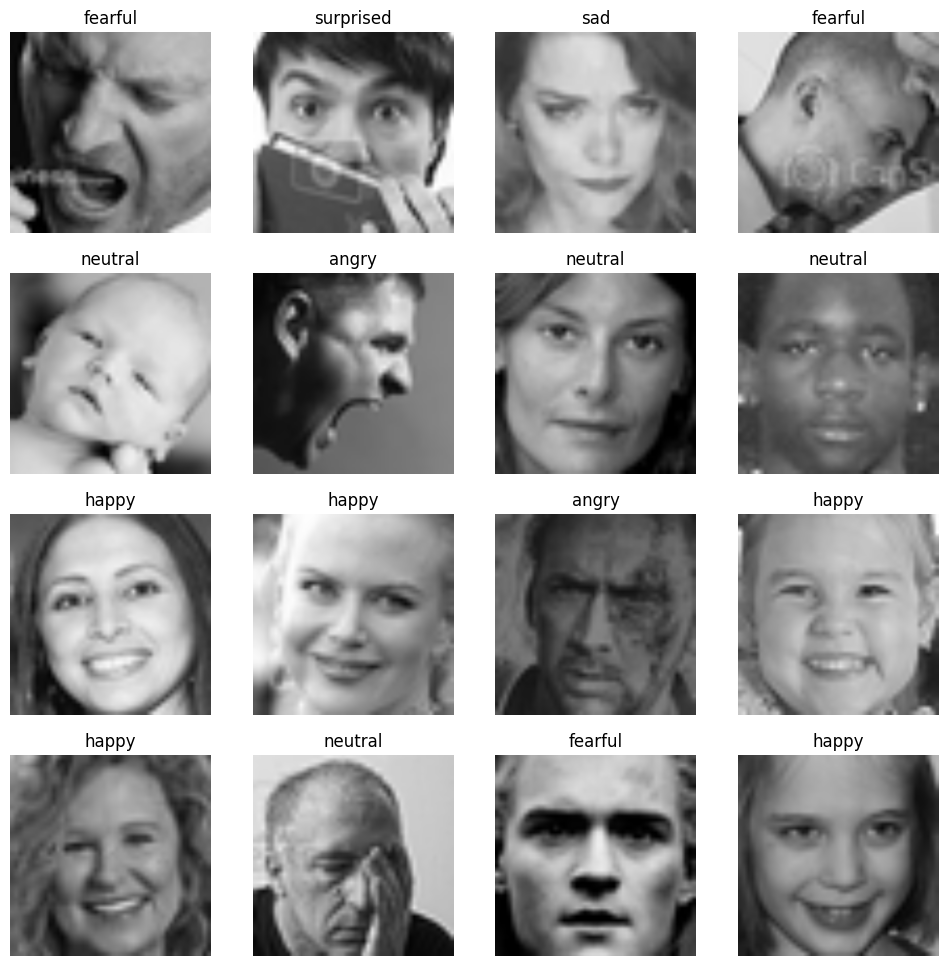

In [ ]:
plt.figure(figsize = (12, 12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

# Data Set Preparation

In [6]:
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [7]:
validation_dataset = (
    validation_dataset
    .prefetch(tf.data.AUTOTUNE)
)

# Modeling

## Resnet Architecture

###  Building Custom Layer

In [32]:
import tensorflow as tf ### Models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Layer, Add, Activation
from tensorflow.keras.models import Model

class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x)

    return x

### Building Residual Block

In [33]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)



    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training = True):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x])

    return self.activation(x_add)


### Resnet Model

In [34]:
class ResNet34(Model):
  def __init__(self):
    super(ResNet34, self).__init__(name = 'resnet_34')


    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(7, activation = 'softmax')

  def call(self, x, training = True):

    x = self.conv_1(x, training)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)

    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)







In [35]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1, 256, 256, 3]), training = False)
resnet_34.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2  multiple                  9728      
 D)                                                              
                                                                 
 max_pooling2d_2 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

### Model Checkpoint Callback

In [12]:
checkpoint_callback = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.tf',
    monitor = 'val_loss',
    save_best_only = True,
)

### Metrics

In [13]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k = 2, name = "top_k_accuracy")]

### Model Compiling

In [14]:
resnet_34.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = loss_function,
    metrics = metrics,
)

### Training

In [16]:
history=resnet_34.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = 20,
    verbose = 1,
    callbacks = [checkpoint_callback]
)

Epoch 1/20
898/898 [==============================] - 204s 227ms/step - loss: 0.7125 - accuracy: 0.7327 - top_k_accuracy: 0.8903 - val_loss: 1.2672 - val_accuracy: 0.5913 - val_top_k_accuracy: 0.7654
Epoch 2/20
898/898 [==============================] - 203s 225ms/step - loss: 0.6608 - accuracy: 0.7536 - top_k_accuracy: 0.9043 - val_loss: 1.2980 - val_accuracy: 0.5822 - val_top_k_accuracy: 0.7654
Epoch 3/20
898/898 [==============================] - 203s 225ms/step - loss: 0.5913 - accuracy: 0.7816 - top_k_accuracy: 0.9196 - val_loss: 1.3360 - val_accuracy: 0.5865 - val_top_k_accuracy: 0.7634
Epoch 4/20
898/898 [==============================] - 202s 224ms/step - loss: 0.5336 - accuracy: 0.8014 - top_k_accuracy: 0.9329 - val_loss: 1.4197 - val_accuracy: 0.5851 - val_top_k_accuracy: 0.7618
Epoch 5/20
898/898 [==============================] - 201s 224ms/step - loss: 0.4753 - accuracy: 0.8220 - top_k_accuracy: 0.9447 - val_loss: 1.5189 - val_accuracy: 0.5815 - val_top_k_accuracy: 0.7687


In [18]:
resnet_34.evaluate(validation_dataset)

225/225 [==============================] - 15s 66ms/step - loss: 2.3380 - accuracy: 0.5981 - top_k_accuracy: 0.7693


[2.3379733562469482, 0.5980774760246277, 0.7692950963973999]

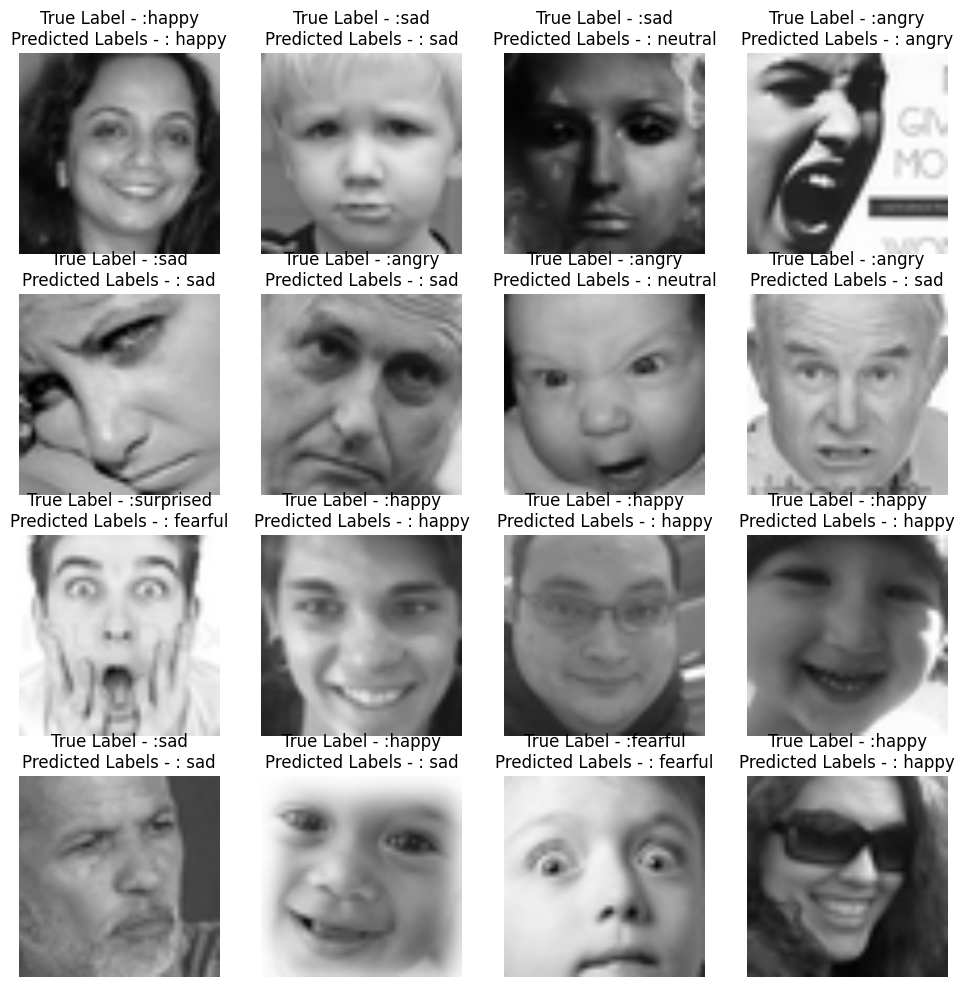

In [22]:
plt.figure(figsize = (12,12))

for images, labels in validation_dataset.take(1):
  for i  in range (16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i]/255.)
    plt.title("True Label - :" + CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()] + "\n" + "Predicted Labels - : " + CLASS_NAMES[tf.argmax(resnet_34(tf.expand_dims(images[i], axis = 0)), axis = -1).numpy()[0]])
    plt.axis("off")

happy


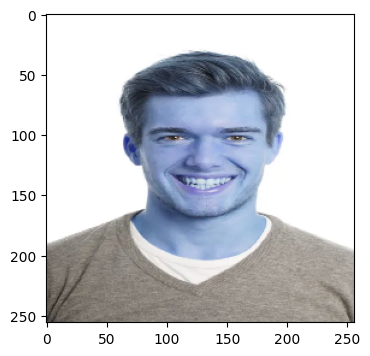

In [47]:
test_image = cv2.imread("/content/depositphotos_38665115-stock-photo-happy-young-man.jpg")
test_image = cv2.resize(test_image, (256, 256))

plt.figure(figsize = (4, 4))
plt.imshow(test_image)

test_image = tf.cast(test_image, tf.float32)
im = tf.expand_dims(test_image, axis = 0)
print(CLASS_NAMES[tf.argmax(resnet_34(im), axis = -1).numpy()[0]])

